[Go to this directory index](./)

Contents
  - [More optimization trials¶](#More-optimization-trials)
      - [Trial 2.1¶](#Trial-2.1)
      - [State points](undefined)
      - [Performance variables](undefined)
      - [Trial 2.2¶](#Trial-2.2)
        - [Aside¶](#Aside)
      - [Trial 2.3¶](#Trial-2.3)
      - [Trial 2.4¶](#Trial-2.4)
      - [Trial 2.5¶](#Trial-2.5)
  - [Scratch work¶](#Scratch-work)

# More optimization trials

Previously, I tried throwing a bunch of optimizers at my model. I liked the results from the scipy.optimize routines COBYLA and BFGS. Let's try adjusting how we handle the constraints, and see if we get better results.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import numpy
from IPython.display import HTML, SVG

In [3]:
#matplotlib.use('svg')
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.sans-serif'] = 'Arial'

In [4]:
from io import BytesIO
def pltsvg():
    imgdata = BytesIO()
    plt.savefig(imgdata)
    imgdata.seek(0)
    display(SVG(data=imgdata.read()))

In [214]:
import ammonia1
import system_aqua1
import scipy.optimize

### Trial 2.1

In general, here is how we compute the modified objective function. GenOpt manual suggests adding functions to the objective, namely separate barrier (B) and penalty (P) functions. The objective function is, with step number as $k$,

$$ Objective = -Q_{cooling}(x) + \mu_1 B(x) + \mu_2 P(x) $$

$$ \mu_1 = k^{-2}$$
$$ B(x) = \left(\sum_{j=1}^{N_B} g_j(x) \right) ^ {-1} $$

$$\mu_2 = k^{2}$$
$$ P(x) = \sum_{j=N_B+1}^{N_B + N_P} g_j(x)$$

GenOpt implements a mechanism to pass in the step number. However, using the scipy.optimize routines, passing in the step number is a challenge, so the `Problem` object should probably use its own counter of function calls. This could be quirky, since then the objective function is changing with each call. Some routines allow for termination after a number of steps, so we could run a while, increment step number, then continue.

But we need to make some decisions.

- Which constraints should be handled by barriers, and which by penalties?
  - Use barriers for hard constraints, eg. required for feasibility of the chiller model
  - Use penalties for soft constraints, eg. heat exchange feasibility that can be violated now and satisfied later
- With scipy.optimize, we can directly apply constraints on the input variables (such as $T_1 > T_2$)



In [35]:
def saturate(x, bottom=-numpy.inf, top=0):
    a_bottom = numpy.empty_like(x)
    a_top = numpy.empty_like(x)
    a_bottom.fill(bottom)
    a_top.fill(top)
    return numpy.minimum(a_top,
                         numpy.maximum(a_bottom,
                                       x))

def barrier1(c, length_scale):
    """The domain for B is the feasible set only.
    We want B large near boundary, but small elsewhere.
    Feasible means c > 0 and g < 0. Please input c.
    """
    g = numpy.negative(c)
    b = numpy.exp(g / length_scale)
    return numpy.sum(b)

def decay1(step_number, initial_value = 1., rate = 1.):
    """A decaying function to scale barrier functions.
    step_number: as this increases, I decay.
    initial_value: value when step_number = 0.
    decay_rate: how fast to decay.
    """
    # Magnitude tends to zero, slowly
    mu_B = initial_value * numpy.exp(-rate * step_number)
    return mu_B        

def penalty1(c, length_scale):
    """We want P = 0 for feasible, P > 0 elsewhere
    Feasible means c > 0 and g < 0.
    """
    g = numpy.negative(c)
    g = saturate(g,bottom=0,top=numpy.inf)
    p = (g / length_scale)**2
    return numpy.sum(p)

def grow1(step_number, initial_value = 1., rate = 1.):
    """A growing function to scale penalty functions."""
    # Magnitude tends to infinite, bit more quickly
    mu_P = initial_value * numpy.exp(rate * step_number)
    return mu_P


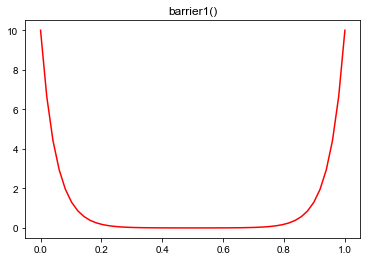

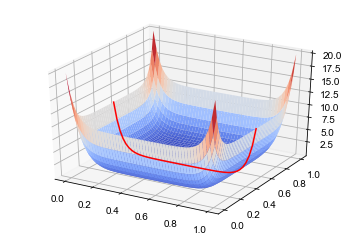

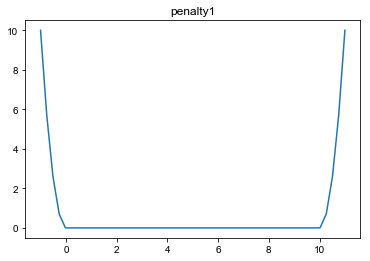

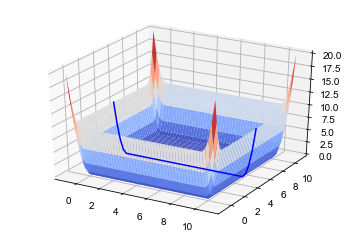

In [41]:
# Demo barriers
xx = numpy.linspace(0,1)
yy = numpy.linspace(0,1)
X, Y = numpy.meshgrid(xx,yy)
B = numpy.zeros_like(X)
mu_B = 10
for i, (xi,yi) in enumerate(zip(X.flat,Y.flat)):
    # The domain for B is the feasible set only.
    # We want B large near boundary, but small elsewhere.
    # Feasible means c > 0 and g < 0.
    c = numpy.array([xi, yi, (1-xi), (1-yi)])
    # The length scale for the barrier
    dx = 0.05
    B.flat[i] = mu_B * barrier1(c,dx)

plt.close('all')
fig = plt.figure()
plt.plot(X[25],B[25],'r')
plt.title("barrier1()")
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,B,cmap=cm.coolwarm)
ax.plot(X[25],Y[25],B[25],'r')
#pltsvg()
plt.show()

xx = numpy.linspace(-1,11)
yy = numpy.linspace(-1,11)
X, Y = numpy.meshgrid(xx,yy)
P = numpy.zeros_like(X)

mu_P = 10
for i, (xi,yi) in enumerate(zip(X.flat,Y.flat)):
    # We want P = 0 for feasible, P > 0 elsewhere
    # Feasible means c > 0 and g < 0.
    c = numpy.array([xi, yi, (10-xi), (10-yi)])
    # The length scale for the penalty
    dx = 1
    P.flat[i] = mu_P * penalty1(c, dx)

plt.close('all')
fig = plt.figure()
plt.plot(X[25],P[25])
plt.title("penalty1")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,P,cmap=cm.coolwarm)
ax.plot(X[25],Y[25],P[25],'b')
#pltsvg()
plt.show()

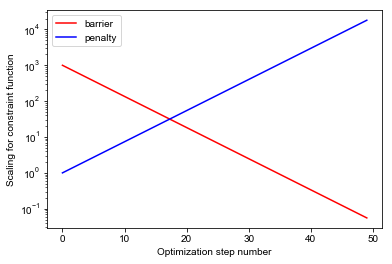

In [44]:
step_number = numpy.arange(50)
mu_B = decay1(step_number,initial_value=1000,rate=0.2)
mu_P = grow1(step_number,initial_value=1,rate=0.2)
plt.close('all')
plt.figure()
plt.semilogy(step_number,mu_B,'r',label='barrier')
plt.semilogy(step_number,mu_P,'b',label='penalty')
plt.xlabel('Optimization step number')
plt.ylabel('Scaling for constraint function')
plt.legend()
plt.show()

In [21]:
step_number = 39
mu_B = 1 * numpy.exp(0.1 * step_number)
mu_B

49.402449105530188

In [181]:
class Problem_2_1:
    def __init__(self, bdry, UAgoal, mu=0.1):
        self.bdry = bdry
        self.UAgoal = UAgoal
        self.mu = mu
        self.Ncons = 7
        self.n_calls = 0
        # Soft constraints mode: this is sent to minimizer
        self.constraints = [{'type': 'ineq',
                             'fun': self.constraint,
                             'args': (i,)
                            } for i in range(self.Ncons)]
            
    def objective(self, xC):
        step_number = numpy.floor(self.n_calls / 7)
        self.n_calls += 1
        print(xC,flush=True)
        Q,B,P = 0.,0.,0.
        try:
            ch = system_aqua1.makeChiller(xC)
            sys = system_aqua1.System(self.bdry, ch)
            
            # Barriers
            # Magnitude tends to zero, slowly
            mu_B = 1000. * numpy.exp(-0.1 * step_number)
            length_scale_b = 1
            # Or ... magnitude fixed, but shape changes
            mu_B = 1000
            length_scale_b = 1 * numpy.exp(-0.1 * step_number)
            
            # These are zero at the boundary ...
            barriers = [ch.check_rectifier_delta_T] \
                        + [deltaT
                           for name, deltaT, epsilon, UA, Qhx in sys.data]
            B = mu_B * barrier1(barriers,length_scale_b)
            
            # Penalties
            # Magnitude tends to infinite
            mu_P = 1 * numpy.exp(0.1 * step_number)
            penalties = [(1.0 - sys.totalUA/self.UAgoal)]
            P = mu_P * penalty1(penalties,1)
            
            Q = sys.chiller.Q_evap
        except:
            Q = numpy.inf
        
        print(self.n_calls, step_number, Q, B, P, "\n", flush=True)
        return -Q + B + P
    
    def constraint(self, x, *args):
        cons = [x[0] - 0.1,
                1. - x[0],
                x[2] - x[1] - 1.0,
                x[3] - x[2] - 0.1,
                x[4] - x[1] - 10.0,
                x[5] - x[3] - 1.0,
                x[5] - x[4] - 1.0]
        if len(args) > 0:
            i, = args
            return cons[i]
        else:
            return cons

    def callback(self, x):
        print("Did an iteration at ", x)

In [182]:
T_heat_reject = 305.
UAgoal = 100
xB = [400, 1, T_heat_reject, 3, T_heat_reject, 5, 285, 4, T_heat_reject, 0.15]
bdry = system_aqua1.makeBoundary(xB)
P = Problem_2_1(bdry, UAgoal)

In [183]:
rT = T_heat_reject
x = numpy.array([0.05, 278.45, rT+7, rT+8, rT+5, 395.15])

In [125]:
x = numpy.array([0.51284472, 277.97717012, 312.16427764, 313.6952877,
               310.24856734, 374.14020482])

In [205]:
P.n_calls = 7 * numpy.floor(P.n_calls / 7)
opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                              constraints=P.constraints, callback=P.callback,
                              options={'disp':True,'maxiter':1000,'rhobeg':0.05})
opt

[  3.35723183e-01   2.78159709e+02   3.12221943e+02   3.13043890e+02
   3.10475563e+02   3.95211794e+02]


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\optimize\_minimize.py:403: RuntimeWarning: Method COBYLA does not support callback.
  warn('Method %s does not support callback.' % method, RuntimeWarning)
C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


Note: Absorber inlet is subcooled
267.0 38.0 118.815227129 1.83964553605e-19 5.87765955217 

[  3.85723183e-01   2.78159709e+02   3.12221943e+02   3.13043890e+02
   3.10475563e+02   3.95211794e+02]
Note: Absorber inlet is subcooled
268.0 38.0 136.510643025 7.56828855898e+81 inf 

[  3.35723183e-01   2.78209709e+02   3.12221943e+02   3.13043890e+02
   3.10475563e+02   3.95211794e+02]
Note: Absorber inlet is subcooled
269.0 38.0 119.02522898 2.98340116676e-18 6.27134717824 

[  3.35723183e-01   2.78159709e+02   3.12271943e+02   3.13043890e+02
   3.10475563e+02   3.95211794e+02]
Note: Absorber inlet is subcooled
270.0 38.0 118.690582757 1.31818327891e-19 5.63438826919 

[  3.35723183e-01   2.78159709e+02   3.12271943e+02   3.13093890e+02
   3.10475563e+02   3.95211794e+02]
Note: Absorber inlet is subcooled
271.0 38.0 118.690582757 1.31818327891e-19 5.63395309103 

[  3.35723183e-01   2.78159709e+02   3.12271943e+02   3.13093890e+02
   3.10525563e+02   3.95211794e+02]
Note: Absorber inlet 

     fun: -108.78569337262947
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 43
  status: 1
 success: True
       x: array([  3.35754329e-01,   2.78159652e+02,   3.12271869e+02,
         3.13093885e+02,   3.10525551e+02,   3.95211787e+02])

In [206]:
x = opt.x
x

array([  3.35754329e-01,   2.78159652e+02,   3.12271869e+02,
         3.13093885e+02,   3.10525551e+02,   3.95211787e+02])

In [ ]:
# Let's bebug bad points encountered during optimization.
# For reference, here is a good case.
good_X1 = numpy.array([0.51284472,
                       277.97717012,
                       312.16427764,
                       313.6952877,
                       310.24856734,
                       374.14020482])
# Now, let's compare some degenerate cases.
# This one requires absorber stream to compute points at high concentrations.
bad_X1 = numpy.array([0.2,
                      290.95402556,
                      306.64229519,
                      313.6952877,
                      300.86211291,
                      384.36256216])
# This one is not feasible, insofar as it yields positive rectifier heat flow,
# that is, heat *input* to rectifier, which should be rejected as "bad" design.
# The cause is that T_abs is very low, so the rich stream is very rich,
# and in fact the rectifier isn't needed...
# So, I'm adding a constraint to keep the absorber warmer than evaporator.
bad_X2 = numpy.array([1.,
                      293.03582607,
                      308.98651075,
                      313.6952877,
                      293.29251019,
                      386.99474])
# This one is also degenerate in the rectifier.
# Try increasing the padding on the constraints.
bad_X3 = numpy.array([1.,
                      292.26696584,
                      301.95207453,
                      314.19203364,
                      293.26696584,
                      389.23622472])
bad_X4 = numpy.array([1.,
                      277.22895294,
                      278.22895294,
                      308.37781922,
                      282.22895294,
                      417.08853392])
x = good_X1

In [207]:
ch = system_aqua1.makeChiller(x)
display(ch)
P.constraint(x)

,T,P,x,h,s,u,v,Qu
rich_abs_outlet,310.526,4.90672,0.511574,-71.9566,0.399293,-72.5604,0.00123051,0
rich_pump_outlet,310.691,15.1852,0.511574,-70.3759,0.400311,-72.2437,0.00123003,-0.001
rich_shx_outlet,350.698,15.1852,0.511574,112.588,0.954023,110.612,0.00130159,-0.001
rich_gen_sat_liquid,352.14,15.1852,0.511574,119.782,0.974617,117.801,0.00130449,0
weak_gen_outlet,395.212,15.1852,0.30058,347.264,1.53717,345.364,0.00125104,0
weak_shx_outlet,336.73,15.1852,0.30058,85.2403,0.820382,83.4896,0.00115292,-0.001
weak_exp_outlet,336.908,4.90672,0.30058,85.2402,0.823901,84.6741,0.00115374,-0.001
gen_vapor_outlet,352.14,15.1852,0.988031,1425.08,4.57477,1269.12,0.102702,1
gen_reflux_inlet,352.14,15.1852,0.511424,119.346,0.973276,117.365,0.00130473,0
refrig_rect_outlet,313.094,15.1852,0.999869,1292.42,4.17683,1162.78,0.0853739,0.996888


[0.23575432887826739,
 0.66424567112173261,
 33.112217153465394,
 0.72201591814776978,
 22.365898497033925,
 81.117901789055793,
 83.686236363635032]

In [208]:
sys = system_aqua1.System(bdry, ch)
sys

Note: Absorber inlet is subcooled


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


name,deltaT,epsilon,UA,Q
gen,2.66874,0.944904,35.1378,191.268
rect,7.90461,0.811331,1.21624,16.7246
abs,1.6352,0.920468,37.6556,181.559
cond,2.22017,0.966795,27.4181,112.029
evap,1.13766,0.982872,33.1324,118.514
total,0,0,134.56,0


In [209]:
1-sys.totalUA/P.UAgoal

-0.3456010499915354

In [210]:
penalty1([(1 - sys.totalUA/P.UAgoal)], 1)

0.11944008575525175

In [211]:
box = numpy.ones_like(x)
box[0] = 0.05
ss = numpy.linspace(-1,1,5)
yyy = numpy.zeros([len(box),len(ss)])
for i,boxi in enumerate(box):
    yy = numpy.zeros_like(ss)
    for j, s in enumerate(ss):
        x_vary = x.copy()
        x_vary[i] += boxi * s
        yyy[i,j] = P.objective(x_vary)
        if (numpy.array(P.constraint(x_vary)) < 0).any():
            yyy[i,j] = numpy.nan

[  2.85754329e-01   2.78159652e+02   3.12271869e+02   3.13093885e+02
   3.10525551e+02   3.95211787e+02]
Note: Absorber inlet is subcooled


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


310.0 44.0 100.865247344 1.43509581919e-55 0.0 

[  3.10754329e-01   2.78159652e+02   3.12271869e+02   3.13093885e+02
   3.10525551e+02   3.95211787e+02]
Note: Absorber inlet is subcooled
311.0 44.0 109.689719727 1.55608826459e-55 0.605129864949 

[  3.35754329e-01   2.78159652e+02   3.12271869e+02   3.13093885e+02
   3.10525551e+02   3.95211787e+02]
Note: Absorber inlet is subcooled
312.0 44.0 118.514192111 5.71096258082e-38 9.72849873818 

[  3.60754329e-01   2.78159652e+02   3.12271869e+02   3.13093885e+02
   3.10525551e+02   3.95211787e+02]
Note: Absorber inlet is subcooled
313.0 44.0 127.338664494 4.55957213255e+27 inf 

[  3.85754329e-01   2.78159652e+02   3.12271869e+02   3.13093885e+02
   3.10525551e+02   3.95211787e+02]
Note: Absorber inlet is subcooled
314.0 44.0 136.163136877 5.56939771765e+146 inf 

[  3.35754329e-01   2.77159652e+02   3.12271869e+02   3.13093885e+02
   3.10525551e+02   3.95211787e+02]
Note: Absorber inlet is subcooled
315.0 44.0 114.338968687 2.40329962213

C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


Note: Absorber inlet is subcooled
325.0 46.0 118.514192111 inf inf 

[  3.35754329e-01   2.78159652e+02   3.12271869e+02   3.12593885e+02
   3.10525551e+02   3.95211787e+02]
Note: Absorber inlet is subcooled
326.0 46.0 118.514192111 7.02641439392e-47 11.8866935038 

[  3.35754329e-01   2.78159652e+02   3.12271869e+02   3.13093885e+02
   3.10525551e+02   3.95211787e+02]
Note: Absorber inlet is subcooled
327.0 46.0 118.514192111 7.02641439392e-47 11.8824151916 

[  3.35754329e-01   2.78159652e+02   3.12271869e+02   3.13593885e+02
   3.10525551e+02   3.95211787e+02]
Note: Absorber inlet is subcooled
328.0 46.0 118.514192111 7.02641439392e-47 11.8748164182 

[  3.35754329e-01   2.78159652e+02   3.12271869e+02   3.14093885e+02
   3.10525551e+02   3.95211787e+02]
Note: Absorber inlet is subcooled
329.0 46.0 118.514192111 7.02641439392e-47 11.8695190366 

[  3.35754329e-01   2.78159652e+02   3.12271869e+02   3.13093885e+02
   3.09525551e+02   3.95211787e+02]
Note: Absorber inlet is subcooled


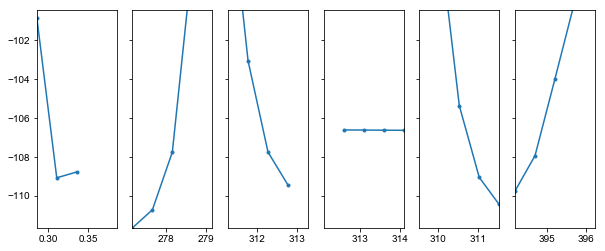

In [213]:
plt.close('all')
plt.figure(figsize=(10, 4))
ax1=plt.subplot(1,len(box), 1)
for i,_ in enumerate(box):
    ax=plt.subplot(1, len(box), i+1, sharey=ax1)
    xxx = x[i] + ss * box[i]
    plt.plot(xxx, yyy[i,:], '.-')
    plt.setp(ax.get_yticklabels(), visible=bool(i==0))
    plt.xlim(min(xxx),max(xxx))
plt.ylim(min(yyy.flat),min(yyy.flat)*0.9)
plt.show()

In [173]:
x = numpy.array([  0.31,   277.8,   313.,
         314.2,   311.5,   394.5])

### Trial 2.2

Just brainstorming ... As a brute-force backup, I would like to have an optimize routine that is a gradient-based method where the gradient calculation and line-search algorithms simply react to passing over the feasible boundary using exceptions instead of constraint functions. (This matters because the total UA constraint function can only be computed when the feasible heat exchange constraints are already satisfied, so in some cases it would have to return infinite values.) In other words, this would be an adaptive step size method. In pseudo-code,

In [ ]:
def optimize(fun,x0,max_iter = 100):
    x = x0.copy()
    for iter in range(max_iter):
        if step == 0:
            break
        G, H = calcGradient(fun, x)
        dx = calcLineSearch(fun, x, G, H)
        x = x + dx
        f = fun(x)
    return x, f

def calcGradient(fun, x0, max_iter = 100):
    max_iter = 100
    # Initial step sizes by component
    deltax = ones_like(x0)
    # Function values to the right
    fplus = zeros_like(x0)
    # Function values to the left
    fminus = zeros_like(x0)
    f0 = fun(x0)
    for j, _ in enumerate(deltax):
        for i in range(max_iter):
            dx = numpy.diag(deltax)[j]
            try:
                xplus = x0 + dx
                xminus = x0 - dx
                fplus[j] = fun(xplus)
                fminus[j] = fun(xminus)
                break
            except:
                deltax[j] *= 0.5
    grad, hess = calcGradHelper(f0, deltax, fplus, fminus) # TODO
    return grad, hess

def calcLineSearch(fun, x0, G, H):
    max_iter = 100
    step = 0
    direction = lshelper1(x0, G, H)
    for i in range(max_iter):
        try:
            lshelper(f
        except:
            step *= 0.5
    return step * direction

#### Aside
Furthermore, here is another related strategy. I could optimize first without the constraint on total UA. That would give me a feasible system. Then, given the desired total UA, I could have a feasible starting point by then turning down the mass flow rate using a linesearch on that parameter.

### Trial 2.3

Another idea (suggested in documention of early trials) is to do something different with the heat exchange feasibility constraints, utilizing energy imbalance. The final goal would be to allow UA values as inputs, and optimize the cooling capacity, as intended. An intermediate goal may be to simply demonstrate a solver with UA values as inputs (using some optimization routine to determine the temperature points that achieve the specified UA values).

### Trial 2.4
New idea: use machine learning to build constraint functions, as follows. Let the optimization routine run. For each input evaluated, classify its feasibility (bonus: add dimensions for root cause of failure). Gather the data for classified points and generate a classification function through regression, etc. Restart the optimizer with this function

### Trial 2.5
An extension of a previous idea, kind of the dual problem -- Perform optimization in two steps: first with no constraint on UA (cost) to determine maximum Q (output). Then for each Q in a set of lesser values, optimize with respect to cost. This will deliver an optimal cost vs output curve.

In [216]:
class Problem_2_5_A:
    def __init__(self, bdry, UAgoal, mu=0.1):
        self.bdry = bdry
        self.UAgoal = UAgoal
        self.mu = mu
        self.Ncons = 7
        self.n_calls = 0
        # Soft constraints mode: this is sent to minimizer
        self.constraints = [{'type': 'ineq',
                             'fun': self.constraint,
                             'args': (i,)
                            } for i in range(self.Ncons)]
            
    def objective(self, xC):
        step_number = numpy.floor(self.n_calls / 7)
        self.n_calls += 1
        print(xC,flush=True)
        Q,B,P = 0.,0.,0.
        try:
            ch = system_aqua1.makeChiller(xC)
            sys = system_aqua1.System(self.bdry, ch)
            
            # Barriers
            # Magnitude tends to zero, slowly
            mu_B = 1000. * numpy.exp(-0.1 * step_number)
            length_scale_b = 1
            # Or ... magnitude fixed, but shape changes
            mu_B = 1000
            length_scale_b = 1 * numpy.exp(-0.1 * step_number)
            
            # These are zero at the boundary ...
            barriers = [ch.check_rectifier_delta_T] \
                        + [deltaT
                           for name, deltaT, epsilon, UA, Qhx in sys.data]
            B = mu_B * barrier1(barriers,length_scale_b)
            
            # Penalties
            # Magnitude tends to infinite
            mu_P = 1 * numpy.exp(0.1 * step_number)
            penalties = [] # nothing to mention
            P = mu_P * penalty1(penalties,1)
            
            Q = sys.chiller.Q_evap
        except:
            Q = numpy.inf
        
        print(self.n_calls, step_number, Q, B, P, "\n", flush=True)
        return -Q + B + P
    
    def constraint(self, x, *args):
        cons = [x[0] - 0.1,
                1. - x[0],
                x[2] - x[1] - 1.0,
                x[3] - x[2] - 0.1,
                x[4] - x[1] - 10.0,
                x[5] - x[3] - 1.0,
                x[5] - x[4] - 1.0]
        if len(args) > 0:
            i, = args
            return cons[i]
        else:
            return cons

    def callback(self, x):
        print("Did an iteration at ", x)

In [228]:
P = Problem_2_5_A(bdry, UAgoal)
rT = T_heat_reject
x = numpy.array([0.05, 278.45, rT+7, rT+8, rT+5, 395.15])

In [264]:
P.n_calls = 7 * numpy.floor(P.n_calls / 7)
opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                              constraints=P.constraints, callback=P.callback,
                              options={'disp':True,'maxiter':1000,'rhobeg':0.001})
opt

[  3.55072116e-01   2.78420757e+02   3.12162856e+02   3.13010725e+02
   3.10417739e+02   3.95273386e+02]


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\optimize\_minimize.py:403: RuntimeWarning: Method COBYLA does not support callback.
  warn('Method %s does not support callback.' % method, RuntimeWarning)


Note: Absorber inlet is subcooled


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


519.0 74.0 127.317339047 5.3349045353e-17 0.0 

[  3.56072116e-01   2.78420757e+02   3.12162856e+02   3.13010725e+02
   3.10417739e+02   3.95273386e+02]
Note: Absorber inlet is subcooled
520.0 74.0 127.675906597 4.74255995465e+80 0.0 

[  3.55072116e-01   2.78421757e+02   3.12162856e+02   3.13010725e+02
   3.10417739e+02   3.95273386e+02]
Note: Absorber inlet is subcooled
521.0 74.0 127.321792771 5.59956626076e-17 0.0 

[  3.55072116e-01   2.78421757e+02   3.12163856e+02   3.13010725e+02
   3.10417739e+02   3.95273386e+02]
Note: Absorber inlet is subcooled
522.0 74.0 127.31917001 6.88659609816e-17 0.0 

[  3.55072116e-01   2.78421757e+02   3.12162856e+02   3.13011725e+02
   3.10417739e+02   3.95273386e+02]
Note: Absorber inlet is subcooled
523.0 74.0 127.321792771 5.59956626076e-17 0.0 

[  3.55072116e-01   2.78421757e+02   3.12162856e+02   3.13010725e+02
   3.10418739e+02   3.95273386e+02]
Note: Absorber inlet is subcooled
524.0 74.0 127.317813373 5.50989357622e-17 0.0 

[  3.55072116

     fun: -127.34895926866595
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 32
  status: 1
 success: True
       x: array([  3.55137672e-01,   2.78421702e+02,   3.12162596e+02,
         3.13010766e+02,   3.10417397e+02,   3.95274447e+02])

In [265]:
x = opt.x
x

array([  3.55137672e-01,   2.78421702e+02,   3.12162596e+02,
         3.13010766e+02,   3.10417397e+02,   3.95274447e+02])

In [266]:
ch = system_aqua1.makeChiller(x)
display(ch)

,T,P,x,h,s,u,v,Qu
rich_abs_outlet,310.417,4.95336,0.514304,-72.3015,0.397627,-72.9118,0.00123198,0
rich_pump_outlet,310.582,15.1389,0.514304,-70.7333,0.398637,-72.5977,0.00123151,-0.001
rich_shx_outlet,350.366,15.1389,0.514304,111.299,0.949892,109.327,0.00130295,-0.001
rich_gen_sat_liquid,351.549,15.1389,0.514304,117.247,0.966967,115.271,0.00130528,0
weak_gen_outlet,395.274,15.1389,0.299694,347.844,1.53814,345.951,0.00125059,0
weak_shx_outlet,336.673,15.1389,0.299694,85.357,0.820092,83.6123,0.00115244,-0.001
weak_exp_outlet,336.849,4.95336,0.299694,85.3569,0.823578,84.7856,0.00115325,-0.001
gen_vapor_outlet,351.549,15.1389,0.988422,1423.24,4.57086,1267.59,0.102817,1
gen_reflux_inlet,351.549,15.1389,0.514161,116.839,0.965702,114.863,0.00130551,0
refrig_rect_outlet,313.011,15.1389,0.999869,1292.69,4.17889,1163.01,0.085662,0.997063


In [267]:
P.constraint(x)

[0.25513767158997736,
 0.64486232841002267,
 32.740894434783854,
 0.7481694634629662,
 21.995695399762837,
 81.263681283164658,
 83.857049781648641]

In [268]:
sys = system_aqua1.System(bdry, ch)
sys

Note: Absorber inlet is subcooled


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


name,deltaT,epsilon,UA,Q
gen,0.017374,0.999645,127.218,204.499
rect,7.79555,0.808195,1.3645,17.6432
abs,1.40685,0.930853,46.2847,194.298
cond,1.71955,0.967192,33.239,120.464
evap,0.348308,0.983386,52.3927,127.349
total,0,0,260.499,0


In [269]:
box = numpy.ones_like(x)
box[0] = 0.05
ss = numpy.linspace(-1,1,5)
yyy = numpy.zeros([len(box),len(ss)])
for i,boxi in enumerate(box):
    yy = numpy.zeros_like(ss)
    for j, s in enumerate(ss):
        x_vary = x.copy()
        x_vary[i] += boxi * s
        yyy[i,j] = P.objective(x_vary)
        if (numpy.array(P.constraint(x_vary)) < 0).any():
            yyy[i,j] = numpy.nan

[  3.05137672e-01   2.78421702e+02   3.12162596e+02   3.13010766e+02
   3.10417397e+02   3.95274447e+02]
Note: Absorber inlet is subcooled


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


551.0 78.0 109.419439331 0.0 0.0 

[  3.30137672e-01   2.78421702e+02   3.12162596e+02   3.13010766e+02
   3.10417397e+02   3.95274447e+02]
Note: Absorber inlet is subcooled
552.0 78.0 118.3841993 0.0 0.0 

[  3.55137672e-01   2.78421702e+02   3.12162596e+02   3.13010766e+02
   3.10417397e+02   3.95274447e+02]
Note: Absorber inlet is subcooled


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


553.0 78.0 127.348959269 3.84223252526e-16 0.0 

[  3.80137672e-01   2.78421702e+02   3.12162596e+02   3.13010766e+02
   3.10417397e+02   3.95274447e+02]
Note: Absorber inlet is subcooled
554.0 79.0 136.313719238 inf 0.0 

[   0.40513767  278.42170204  312.16259647  313.01076594  310.41739744
  395.27444722]


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


Note: Absorber inlet is subcooled
555.0 79.0 145.278479206 inf 0.0 

[  3.55137672e-01   2.77421702e+02   3.12162596e+02   3.13010766e+02
   3.10417397e+02   3.95274447e+02]
Note: Absorber inlet is subcooled
556.0 79.0 122.919133181 3.10637374978e-46 0.0 

[  3.55137672e-01   2.77921702e+02   3.12162596e+02   3.13010766e+02
   3.10417397e+02   3.95274447e+02]
Note: Absorber inlet is subcooled
557.0 79.0 125.127943709 2.55433035295e-33 0.0 

[  3.55137672e-01   2.78421702e+02   3.12162596e+02   3.13010766e+02
   3.10417397e+02   3.95274447e+02]
Note: Absorber inlet is subcooled
558.0 79.0 127.348959269 4.44444359796e-18 0.0 

[  3.55137672e-01   2.78921702e+02   3.12162596e+02   3.13010766e+02
   3.10417397e+02   3.95274447e+02]
Note: Absorber inlet is subcooled
559.0 79.0 129.582653934 inf 0.0 

[  3.55137672e-01   2.79421702e+02   3.12162596e+02   3.13010766e+02
   3.10417397e+02   3.95274447e+02]
Note: Absorber inlet is subcooled
560.0 79.0 131.829513357 inf 0.0 

[  3.55137672e-01  

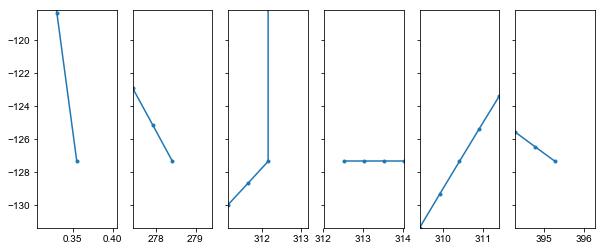

In [270]:
plt.close('all')
plt.figure(figsize=(10, 4))
ax1=plt.subplot(1,len(box), 1)
for i,_ in enumerate(box):
    ax=plt.subplot(1, len(box), i+1, sharey=ax1)
    xxx = x[i] + ss * box[i]
    plt.plot(xxx, yyy[i,:], '.-')
    plt.setp(ax.get_yticklabels(), visible=bool(i==0))
    plt.xlim(min(xxx),max(xxx))
plt.ylim(min(yyy.flat),min(yyy.flat)*0.9)
plt.show()

# Scratch work

In [15]:
a=5
for i in range(9999):
    a*=0.5
    if a==0:
        break
i,a

(1076, 0.0)

In [25]:
gradient_step = numpy.array([1.,2.,3.,4.])
for j, _ in enumerate(gradient_step):
    for i in range(2):
        gradient_step[j] *= 0.5
gradient_step

array([ 0.25,  0.5 ,  0.75,  1.  ])

In [30]:
numpy.diag(gradient_step)[3]

array([ 0.,  0.,  0.,  1.])

In [215]:
%%html
<pre id="TOC-markdown">TOC will be here</pre>
<script>
$("#TOC-markdown").html(
    $('h1,h2,h3,h4').map(function(){return "  ".repeat($(this).prop("tagName")[1]) + "- ["+$(this).text()+"](" + $(this).children().attr("href") + ")";}).get().join("\n")
    );
</script>